# Paso 4 - Inferencia (scoring)

**Flujo**: Cargar modelo calibrado y features desde **models/** → cargar dataset wide de inferencia → obtener scores P(fraud) → guardar CSV en **data/predictions/**.

- **Input**: `models/lgbm_model_cal.pkl`, `models/features.pkl`, `data/processed/inference/cutoff=<CUTOFF>/inference_wide.parquet` (generado por `2_dataset_creation.ipynb` en modo inference).
- **Output**: `data/predictions/scores_<CUTOFF>.csv` (contrato, score).

---
## 1. Imports y path del proyecto

Se agrega la raíz del proyecto a `sys.path`.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import joblib
import warnings

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

---
## 2. Configuración

Rutas y fecha de corte. El CUTOFF debe coincidir con la fecha con la que se generó `inference_wide.parquet` en `2_dataset_creation.ipynb` (modo inference).

In [2]:
PROCESSED_DIR = "../data/processed"
MODELS_DIR = "../models"
PREDICTIONS_DIR = "../data/predictions"

# Misma fecha de corte con la que se generó inference_wide en 2_dataset_creation (modo inference)
CUTOFF = "2025-08-01"

---
## 3. Cargar modelo y features

Se cargan el modelo calibrado y la lista de columnas desde **models/**.

In [3]:
model = joblib.load(os.path.join(MODELS_DIR, "lgbm_model_cal.pkl"))
cols_for_model = joblib.load(os.path.join(MODELS_DIR, "features.pkl"))
print(f"Modelo y {len(cols_for_model)} features cargados.")

Modelo y 54 features cargados.


---
## 4. Cargar dataset de inferencia

Se lee el parquet wide generado por `2_dataset_creation.ipynb` en modo inference (sin target).

In [4]:
inference_path = os.path.join(PROCESSED_DIR, "inference", f"cutoff={CUTOFF}", "inference_wide.parquet")
df = pd.read_parquet(inference_path)
print(f"Inferencia: {len(df)} filas")

Inferencia: 11019 filas


---
## 5. Validar columnas y scoring

Se comprueba que existan todas las columnas de **cols_for_model** y se obtienen los scores P(fraud).

In [5]:
missing = [c for c in cols_for_model if c not in df.columns]
if missing:
    raise ValueError(f"Columnas faltantes en inference_wide: {missing}")

scores = model.predict_proba(df[cols_for_model])[:, 1]
df_out = df[["contrato"]].copy()
df_out["score"] = scores
print(f"Scores calculados: {len(df_out)} registros")

Scores calculados: 11019 registros


---
## 6. Guardar CSV en data/predictions

Se guarda el resultado directamente en **data/predictions/** (sin subcarpetas), con nombre `scores_<CUTOFF>.csv`.

In [6]:
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
out_path = os.path.join(PREDICTIONS_DIR, f"scores_{CUTOFF}.csv")
df_out.to_csv(out_path, index=False)
print(f"[OK] Guardado: {out_path}")

[OK] Guardado: ../data/predictions\scores_2025-08-01.csv


---
## 7. Distribución del score (opcional)

Histograma del score en el conjunto de inferencia.

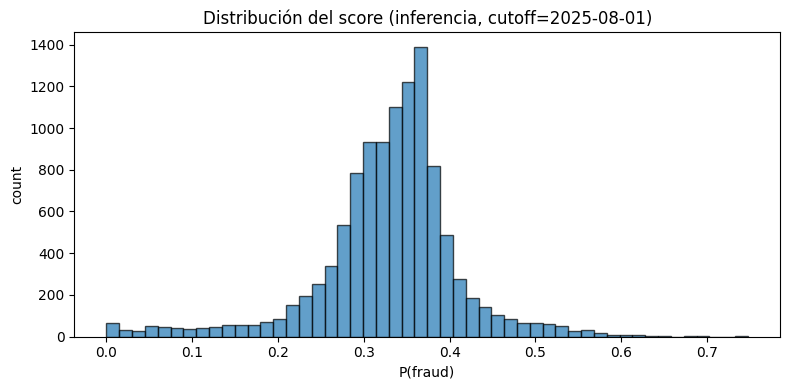

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df_out["score"], bins=50, edgecolor="black", alpha=0.7)
plt.title(f"Distribución del score (inferencia, cutoff={CUTOFF})")
plt.xlabel("P(fraud)")
plt.ylabel("count")
plt.tight_layout()
plt.show()